In [1]:
import kde
import pycisTopic
import glob
import os
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import multiprocess as mp
from multiprocess import Pool
import pprint as pp


def histogram(array, nbins=100):
    """
    Draw histogram from distribution and identify centers.
    Parameters
    ---------
    array: `class::np.array`
            Scores distribution
    nbins: int
            Number of bins to use in the histogram
    Return
    ---------
    float
            Histogram values and bin centers.
    """
    array = array.ravel().flatten()
    hist, bin_edges = np.histogram(array, bins=nbins, range=None)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2.0
    return hist, bin_centers


def threshold_otsu(array, nbins=100, min_value=100):
    """
    Apply Otsu threshold on topic-region distributions [Otsu, 1979].
    Parameters
    ---------
    array: `class::np.array`
            Array containing the region values for the topic to be binarized.
    nbins: int
            Number of bins to use in the binarization histogram
    Return
    ---------
    float
            Binarization threshold.
    Reference
    ---------
    Otsu, N., 1979. A threshold selection method from gray-level histograms. IEEE transactions on systems, man, and
    cybernetics, 9(1), pp.62-66.
    """
    array = array[(array >= min_value)]
    hist, bin_centers = histogram(array, nbins)
    hist = hist.astype(float)
    # Class probabilities for all possible thresholds
    weight1 = np.cumsum(hist)
    weight2 = np.cumsum(hist[::-1])[::-1]
    # Class means for all possible thresholds
    mean1 = np.cumsum(hist * bin_centers) / weight1
    mean2 = (np.cumsum((hist * bin_centers)[::-1]) / weight2[::-1])[::-1]
    # Clip ends to align class 1 and class 2 variables:
    # The last value of ``weight1``/``mean1`` should pair with zero values in
    # ``weight2``/``mean2``, which do not exist.
    variance12 = weight1[:-1] * weight2[1:] * (mean1[:-1] - mean2[1:]) ** 2
    idx = np.argmax(variance12)
    threshold = bin_centers[:-1][idx]
    mean_selected = np.median(array[(array >= threshold)])
    score = np.sqrt(max(variance12)) / mean_selected
    return threshold, score

In [2]:
%load_ext lab_black

In [3]:
os.chdir("/lustre1/project/stg_00090/scatac_benchmark/full_3_cistopic_consensus")

In [11]:
metadata_bc_pkl_list = sorted(glob.glob("cistopic_qc_out_CONSENSUS/*metadata_bc.pkl"))
metadata_bc_pkl_path_dict = {}
for metadata_bc_pkl_path in metadata_bc_pkl_list:
    sample = metadata_bc_pkl_path.split("/")[-1].split("__metadata_bc.pkl")[0]
    metadata_bc_pkl_path_dict[sample] = metadata_bc_pkl_path

metadata_bc_pkl_path_dict.pop("VIB_hydrop_11.FULL")
metadata_bc_pkl_path_dict.pop("VIB_hydrop_12.FULL")
metadata_bc_pkl_path_dict.pop("VIB_hydrop_21.FULL")
metadata_bc_pkl_path_dict.pop("VIB_hydrop_22.FULL")

'cistopic_qc_out_CONSENSUS/VIB_hydrop_22.FULL__metadata_bc.pkl'

In [19]:
metadata_bc_pkl_path_dict

{'BIO_ddseq_1.FULL': 'cistopic_qc_out_CONSENSUS/BIO_ddseq_1.FULL__metadata_bc.pkl',
 'BIO_ddseq_2.FULL': 'cistopic_qc_out_CONSENSUS/BIO_ddseq_2.FULL__metadata_bc.pkl',
 'BIO_ddseq_3.FULL': 'cistopic_qc_out_CONSENSUS/BIO_ddseq_3.FULL__metadata_bc.pkl',
 'BIO_ddseq_4.FULL': 'cistopic_qc_out_CONSENSUS/BIO_ddseq_4.FULL__metadata_bc.pkl',
 'BRO_mtscatac_1.FULL': 'cistopic_qc_out_CONSENSUS/BRO_mtscatac_1.FULL__metadata_bc.pkl',
 'BRO_mtscatac_2.FULL': 'cistopic_qc_out_CONSENSUS/BRO_mtscatac_2.FULL__metadata_bc.pkl',
 'CNA_10xmultiome_1.FULL': 'cistopic_qc_out_CONSENSUS/CNA_10xmultiome_1.FULL__metadata_bc.pkl',
 'CNA_10xmultiome_2.FULL': 'cistopic_qc_out_CONSENSUS/CNA_10xmultiome_2.FULL__metadata_bc.pkl',
 'CNA_10xv11_1.FULL': 'cistopic_qc_out_CONSENSUS/CNA_10xv11_1.FULL__metadata_bc.pkl',
 'CNA_10xv11_2.FULL': 'cistopic_qc_out_CONSENSUS/CNA_10xv11_2.FULL__metadata_bc.pkl',
 'CNA_10xv11_3.FULL': 'cistopic_qc_out_CONSENSUS/CNA_10xv11_3.FULL__metadata_bc.pkl',
 'CNA_10xv11_4.FULL': 'cistopic_qc

In [12]:
standard_min_x_val = 100
standard_min_y_val = 1
min_otsu_frags_dict = {}
min_otsu_tss_dict = {}
for metadata_bc_pkl_path in sorted(metadata_bc_pkl_path_dict.keys()):
    sample = metadata_bc_pkl_path.split("/")[-1].split("__metadata_bc.pkl")[0]
    tech = sample.split("_")[1]
    if tech == "ddseq":
        if "BIO_ddseq_1.FULL" in sample:
            min_otsu_frags_dict[sample] = 600
        else:
            min_otsu_frags_dict[sample] = 300
    elif tech == "hydrop":
        min_otsu_frags_dict[sample] = 300
    else:
        min_otsu_frags_dict[sample] = standard_min_x_val

    if tech == "s3atac":
        min_otsu_tss_dict[sample] = 0
    else:
        min_otsu_tss_dict[sample] = standard_min_y_val

In [13]:
all_order = [
    "VIB_10xv1_1.FULL",
    "VIB_10xv1_2.FULL",
    "CNA_10xv11_1.FULL",
    "CNA_10xv11_2.FULL",
    "CNA_10xv11_3.FULL",
    "CNA_10xv11_4.FULL",
    "CNA_10xv11_5.FULL",
    "STA_10xv11_1.FULL",
    "STA_10xv11_2.FULL",
    "TXG_10xv11_1.FULL",
    "CNA_10xv2_1.FULL",
    "CNA_10xv2_2.FULL",
    "TXG_10xv2_1.FULL",
    "TXG_10xv2_2.FULL",
    "VIB_10xv2_1.FULL",
    "VIB_10xv2_2.FULL",
    "CNA_10xmultiome_1.FULL",
    "CNA_10xmultiome_2.FULL",
    "SAN_10xmultiome_1.FULL",
    "SAN_10xmultiome_2.FULL",
    "VIB_10xmultiome_1.FULL",
    "VIB_10xmultiome_2.FULL",
    "BRO_mtscatac_1.FULL",
    "BRO_mtscatac_2.FULL",
    "CNA_mtscatac_1.FULL",
    "CNA_mtscatac_2.FULL",
    "MDC_mtscatac_1.FULL",
    "MDC_mtscatac_2.FULL",
    "BIO_ddseq_1.FULL",
    "BIO_ddseq_2.FULL",
    "BIO_ddseq_3.FULL",
    "BIO_ddseq_4.FULL",
    "HAR_ddseq_1.FULL",
    "HAR_ddseq_2.FULL",
    "UCS_ddseq_1.FULL",
    "UCS_ddseq_2.FULL",
    "OHS_s3atac_1.FULL",
    "OHS_s3atac_2.FULL",
    "CNA_hydrop_1.FULL",
    "CNA_hydrop_2.FULL",
    "CNA_hydrop_3.FULL",
    "EPF_hydrop_1.FULL",
    "EPF_hydrop_2.FULL",
    "EPF_hydrop_3.FULL",
    "EPF_hydrop_4.FULL",
    "VIB_hydrop_1.FULL",
    "VIB_hydrop_2.FULL",
]

sample_id_ultrashort_alias_dict = {
    "BIO_ddseq_1.FULL": "ddS Bi1",
    "BIO_ddseq_2.FULL": "ddS Bi2",
    "BIO_ddseq_3.FULL": "ddS Bi3",
    "BIO_ddseq_4.FULL": "ddS Bi4",
    "BRO_mtscatac_1.FULL": "mt* Br1",
    "BRO_mtscatac_2.FULL": "mt* Br2",
    "CNA_10xmultiome_1.FULL": "MO C1",
    "CNA_10xmultiome_2.FULL": "MO C2",
    "CNA_10xv11_1.FULL": "v1.1 C1",
    "CNA_10xv11_2.FULL": "v1.1 C2",
    "CNA_10xv11_3.FULL": "v1.1 C3",
    "CNA_10xv11_4.FULL": "v1.1c C1",
    "CNA_10xv11_5.FULL": "v1.1c C2",
    "CNA_10xv2_1.FULL": "v2 C1",
    "CNA_10xv2_2.FULL": "v2 C2",
    "CNA_hydrop_1.FULL": "Hy C1",
    "CNA_hydrop_2.FULL": "Hy C2",
    "CNA_hydrop_3.FULL": "Hy C3",
    "CNA_mtscatac_1.FULL": "mt C1",
    "CNA_mtscatac_2.FULL": "mt C2",
    "EPF_hydrop_1.FULL": "Hy E1",
    "EPF_hydrop_2.FULL": "Hy E2",
    "EPF_hydrop_3.FULL": "Hy E3",
    "EPF_hydrop_4.FULL": "Hy E4",
    "HAR_ddseq_1.FULL": "ddS H1",
    "HAR_ddseq_2.FULL": "ddS H2",
    "MDC_mtscatac_1.FULL": "mt M1",
    "MDC_mtscatac_2.FULL": "mt M2",
    "OHS_s3atac_1.FULL": "s3 O1",
    "OHS_s3atac_2.FULL": "s3 O2",
    "SAN_10xmultiome_1.FULL": "MO Sa1",
    "SAN_10xmultiome_2.FULL": "MO Sa2",
    "STA_10xv11_1.FULL": "v1.1 St1",
    "STA_10xv11_2.FULL": "v1.1 St2",
    "TXG_10xv11_1.FULL": "v1.1 T1",
    "TXG_10xv2_1.FULL": "v2 T1",
    "TXG_10xv2_2.FULL": "v2 T2",
    "UCS_ddseq_1.FULL": "ddS U1",
    "UCS_ddseq_2.FULL": "ddS U2",
    "VIB_10xmultiome_1.FULL": "MO V1",
    "VIB_10xmultiome_2.FULL": "MO V2",
    "VIB_10xv1_1.FULL": "v1 V1",
    "VIB_10xv1_2.FULL": "v1 V2",
    "VIB_10xv2_1.FULL": "v2 V1",
    "VIB_10xv2_2.FULL": "v2 V2",
    "VIB_hydrop_1.FULL": "Hy V1",
    "VIB_hydrop_2.FULL": "Hy V2",
    "VIB_hydrop_11.FULL": "Hy V1",
    "VIB_hydrop_12.FULL": "Hy V1",
    "VIB_hydrop_21.FULL": "Hy V2",
    "VIB_hydrop_22.FULL": "Hy V2",
}

tech_color_palette = {
    "10xv2": "#1b9e77",
    "10xv1": "#d95f02",
    "10xv11": "#7570b3",
    "10xmultiome": "#e7298a",
    "mtscatac": "#66a61e",
    "ddseq": "#e6ab02",
    "s3atac": "#a6761d",
    "hydrop": "#666666",
}

In [14]:
!cat kde_intermediate.py

import kde
import glob
import os
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import multiprocess as mp
from multiprocess import Pool
import pprint as pp
all_order = [
    "VIB_10xv1_1.FULL",
    "VIB_10xv1_2.FULL",
    "CNA_10xv11_1.FULL",
    "CNA_10xv11_2.FULL",
    "CNA_10xv11_3.FULL",
    "CNA_10xv11_4.FULL",
    "CNA_10xv11_5.FULL",
    "STA_10xv11_1.FULL",
    "STA_10xv11_2.FULL",
    "TXG_10xv11_1.FULL",
    "CNA_10xv2_1.FULL",
    "CNA_10xv2_2.FULL",
    "TXG_10xv2_1.FULL",
    "TXG_10xv2_2.FULL",
    "VIB_10xv2_1.FULL",
    "VIB_10xv2_2.FULL",
    "CNA_10xmultiome_1.FULL",
    "CNA_10xmultiome_2.FULL",
    "SAN_10xmultiome_1.FULL",
    "SAN_10xmultiome_2.FULL",
    "VIB_10xmultiome_1.FULL",
    "VIB_10xmultiome_2.FULL",
    "BRO_mtscatac_1.FULL",
    "BRO_mtscatac_2.FULL",
    "CNA_mtscatac_1.FULL",
    "CNA_mtscatac_2.FULL",
    "MDC_mtscatac_1.FULL",
    "MDC_mtscatac_2.FULL",
    "BIO_ddseq_1.FULL",
    "BIO_dds

selected_barcodes/VIB_10xv1_1.FULL_bc_passing_filters_otsu.pkl bc passing filters does not exist yet, generating...
	Loading cistopic_qc_out_CONSENSUS/VIB_10xv1_1.FULL__metadata_bc.pkl
	Filtering cells and generating QC plots.
selected_barcodes/VIB_10xv1_2.FULL_bc_passing_filters_otsu.pkl bc passing filters does not exist yet, generating...
	Loading cistopic_qc_out_CONSENSUS/VIB_10xv1_2.FULL__metadata_bc.pkl
	Filtering cells and generating QC plots.
selected_barcodes/CNA_10xv11_1.FULL_bc_passing_filters_otsu.pkl bc passing filters does not exist yet, generating...
	Loading cistopic_qc_out_CONSENSUS/CNA_10xv11_1.FULL__metadata_bc.pkl
	Filtering cells and generating QC plots.
selected_barcodes/CNA_10xv11_2.FULL_bc_passing_filters_otsu.pkl bc passing filters does not exist yet, generating...
	Loading cistopic_qc_out_CONSENSUS/CNA_10xv11_2.FULL__metadata_bc.pkl
	Filtering cells and generating QC plots.
selected_barcodes/CNA_10xv11_3.FULL_bc_passing_filters_otsu.pkl bc passing filters does 

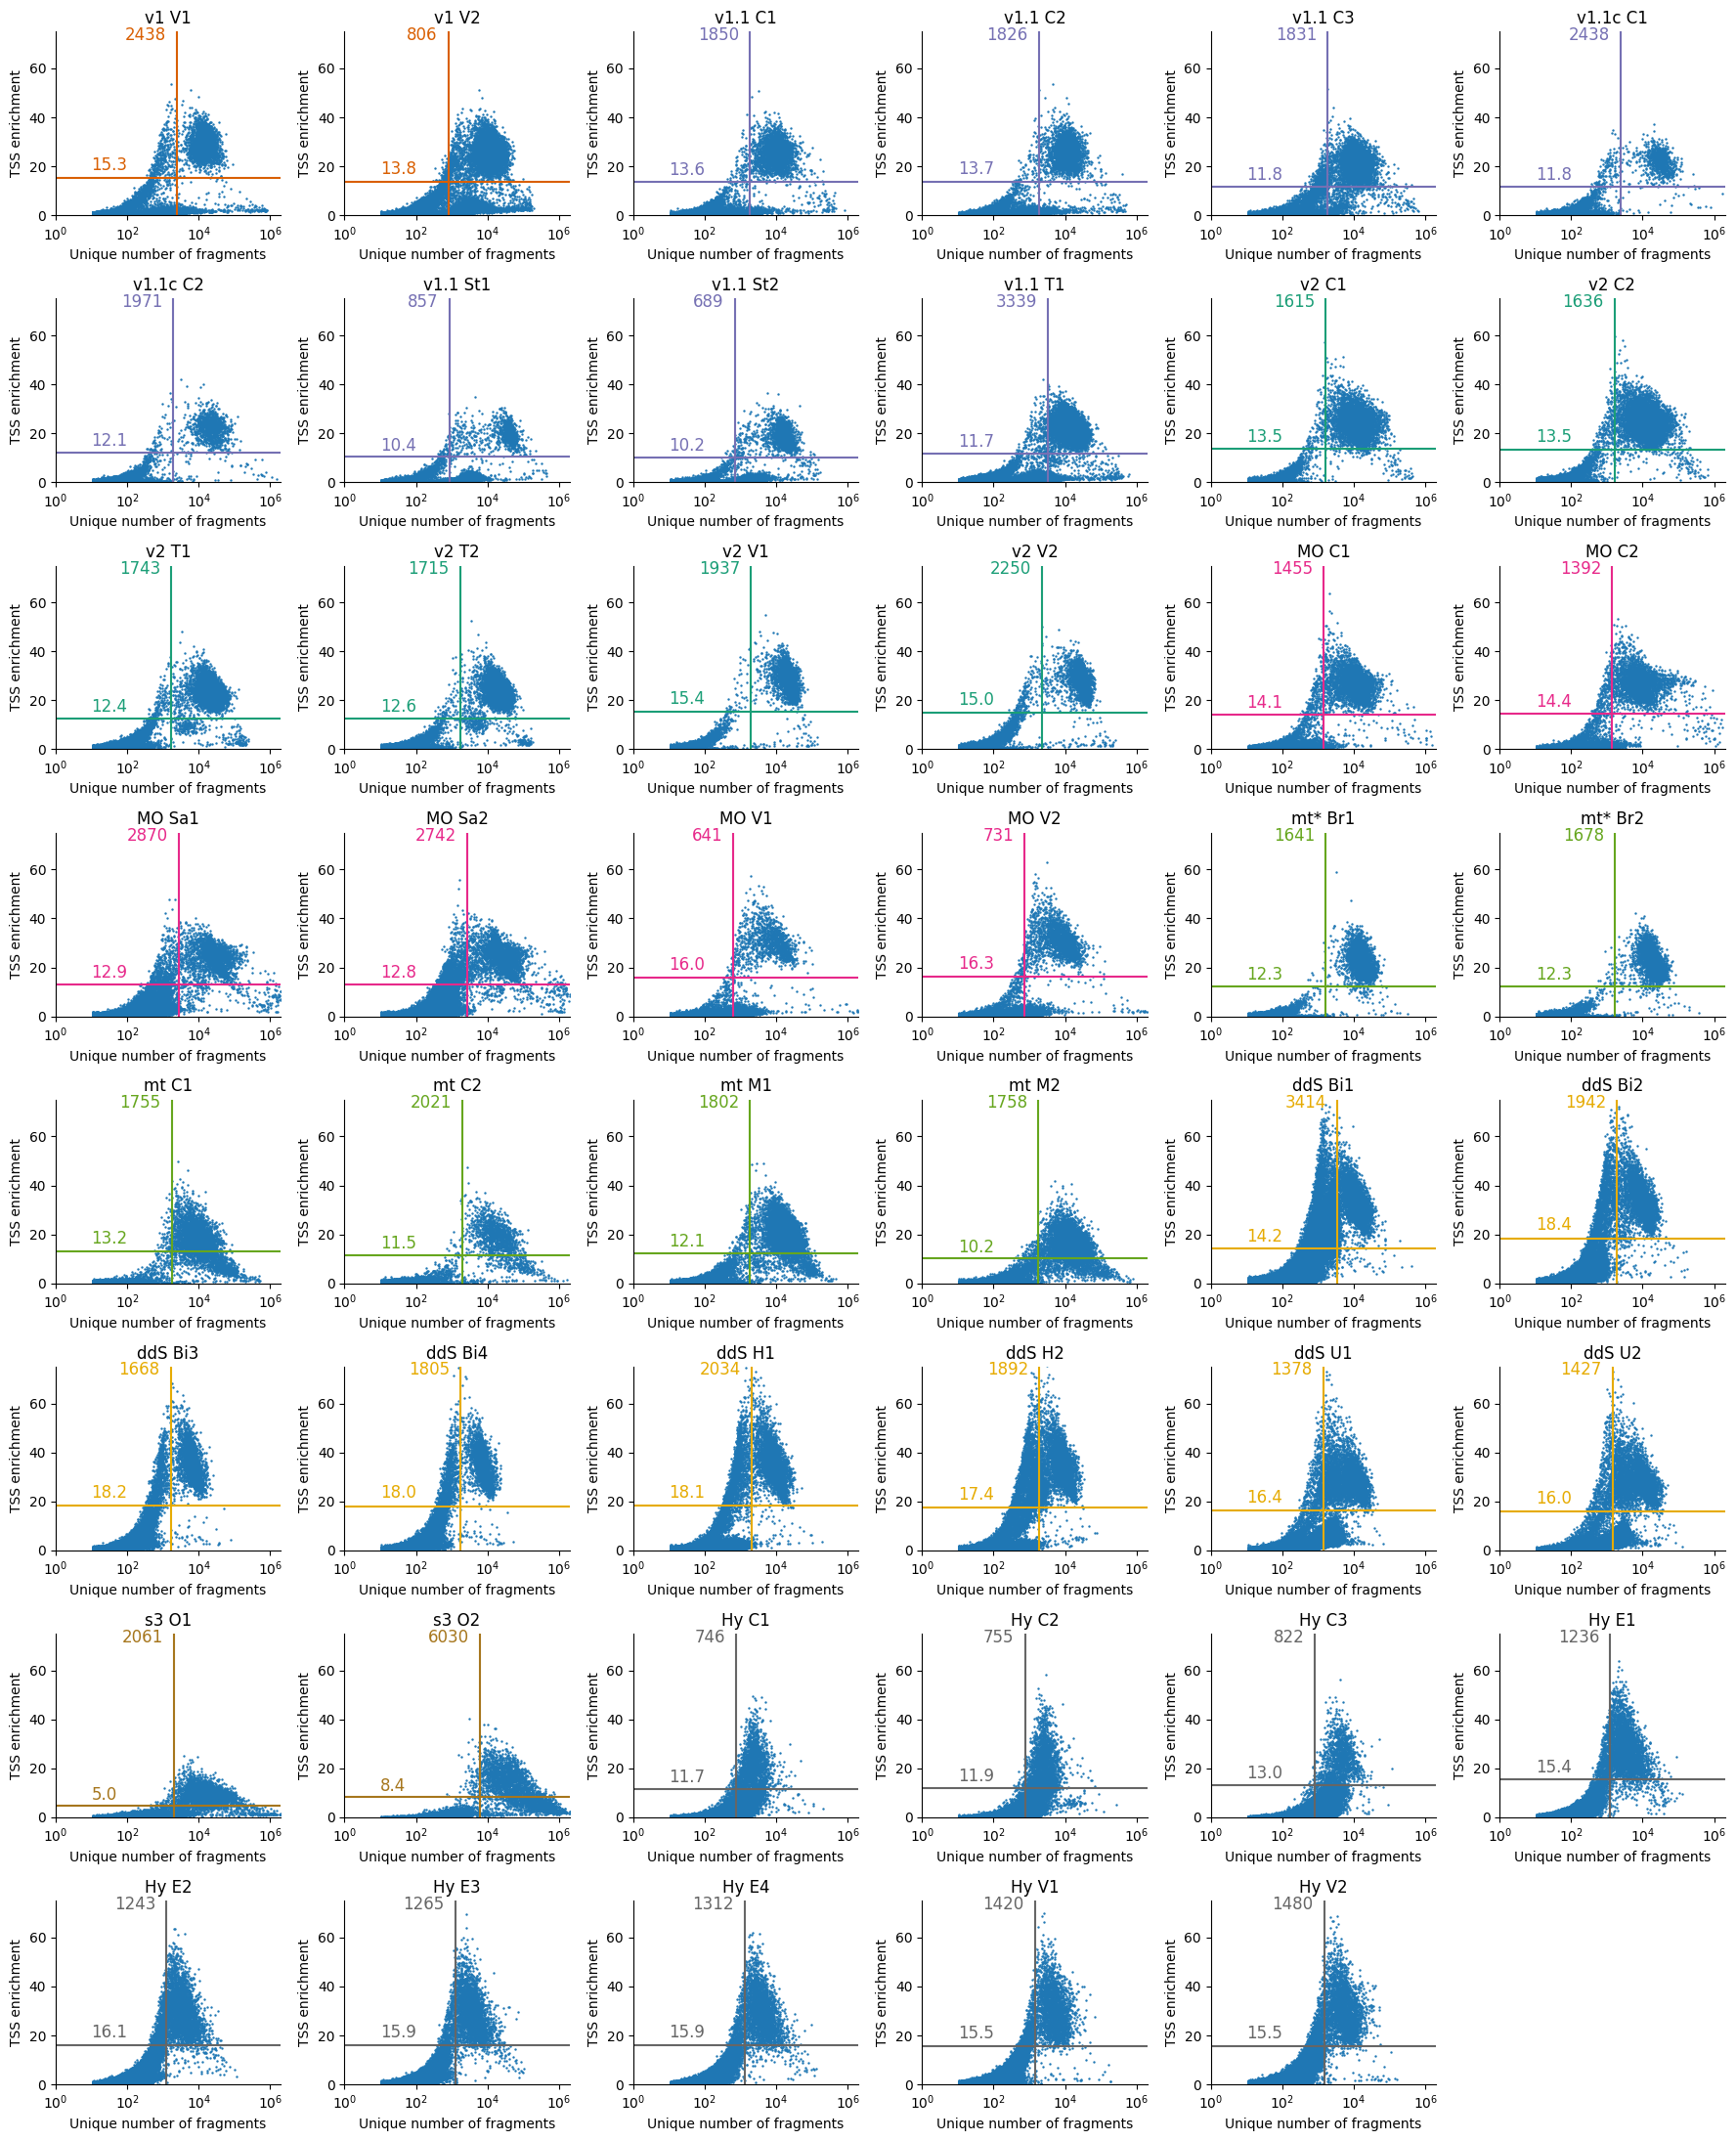

In [15]:
fig, axes = plt.subplots(8, 6, figsize=(18, 22))  # , sharex=True, sharey=True)
axes = axes.flatten()


for sample in all_order:
    tech = sample.split("_")[1]
    pkl_path = f"selected_barcodes/{sample}_bc_passing_filters_otsu.pkl"
    print(f"{pkl_path} bc passing filters does not exist yet, generating...")
    print(f"\tLoading {metadata_bc_pkl_path_dict[sample]}")
    with open(metadata_bc_pkl_path_dict[sample], "rb") as fh:
        metadata_bc_df = pickle.load(fh)

    print(f"\tFiltering cells and generating QC plots.")
    if not sample in min_otsu_frags_dict.keys():
        print(
            f"\t{sample} not in minimum dict! Using standard value of {standard_min_x_val}"
        )
        min_x_val = standard_min_x_val
        min_y_val = standard_min_y_val
    else:
        min_x_val = min_otsu_frags_dict[sample]
        min_y_val = min_otsu_tss_dict[sample]

    # calculate thresholds using a double otsu strategy:
    # first we calculate an otsu threshold using a minimum of 10 fragments
    # then, this otsu threshold is used as the minimum for the second iteration

    x_arr = np.log10(metadata_bc_df["Unique_nr_frag"])
    x_threshold_log, x_score = threshold_otsu(
        x_arr, nbins=5000, min_value=np.log10(min_x_val)
    )
    x_threshold = 10**x_threshold_log

    # cell_filtering_quality_score_df.at[sample, "frag_filter_score2"] = x_score2

    y_arr = metadata_bc_df["TSS_enrichment"]
    y_threshold, y_score = threshold_otsu(y_arr, nbins=5000, min_value=min_y_val)

    # cell_filtering_quality_score_df.at[sample, "TSS_filter_score2"] = y_score2

    ax = axes[all_order.index(sample)]
    sns.scatterplot(
        data=metadata_bc_df,
        x="Unique_nr_frag",
        y="TSS_enrichment",
        # hue="consensus_cell_type",
        # palette=cell_type_color_dict,
        s=3,
        linewidth=0,
        ax=ax,
    )
    ax.hlines(y=y_threshold, xmin=1, xmax=3000000, color=tech_color_palette[tech])
    ax.vlines(x=x_threshold, ymin=0, ymax=100, color=tech_color_palette[tech])

    ax.text(
        x=x_threshold * 0.5,
        y=70,
        s=str(int(x_threshold)),
        ha="right",
        va="bottom",
        color=tech_color_palette[tech],
        fontsize=12,
    )
    ax.text(
        x=10,
        y=y_threshold * 1.1,
        s=str(round(y_threshold, 1)),
        ha="left",
        va="bottom",
        color=tech_color_palette[tech],
        fontsize=12,
    )

    sns.despine(ax=ax, top=True, right=True)
    # ax.set_xticklabels([])
    # ax.set_yticklabels([])
    ax.set_xscale("log")
    # ax.set_yscale('log')
    ax.set_xlim([1, 2000000])
    ax.set_ylim([0, 75])

    ax.set_xlabel("Unique number of fragments")
    ax.set_ylabel("TSS enrichment")
    # ax.text(
    #     x=10,
    #     y=70,
    #     s=f"{sample_id_ultrashort_alias_dict[sample]}",
    #     ha="left",
    #     va="bottom",
    #     color=tech_color_palette[tech],
    # )
    ax.set_title(f"{sample_id_ultrashort_alias_dict[sample]}")
plt.tight_layout()
axes[-1].remove()

plt.savefig("plots_qc/all_tss_nokde.png", dpi=600)

In [16]:
density_paths = {
    x.split("/")[-1].split("__")[0]: x
    for x in sorted(glob.glob("intermediate_df/*TSS*"))
}

In [ ]:
fig, axes = plt.subplots(8, 6, figsize=(18, 22))  # , sharex=True, sharey=True)
axes = axes.flatten()


for sample in all_order:
    tech = sample.split("_")[1]
    pkl_path = f"selected_barcodes/{sample}_bc_passing_filters_otsu.pkl"
    print(f"{pkl_path} bc passing filters does not exist yet, generating...")
    print(f"\tLoading {density_paths[sample]}")
    metadata_bc_df = pd.read_csv(density_paths[sample], header=None, index_col=0)
    metadata_bc_df.columns = ["Unique_nr_frag", "TSS_enrichment", "z"]

    print(f"\tFiltering cells and generating QC plots.")
    if not sample in min_otsu_frags_dict.keys():
        print(
            f"\t{sample} not in minimum dict! Using standard value of {standard_min_x_val}"
        )
        min_x_val = standard_min_x_val
        min_y_val = standard_min_y_val
    else:
        min_x_val = min_otsu_frags_dict[sample]
        min_y_val = min_otsu_tss_dict[sample]

    # calculate thresholds using a double otsu strategy:
    # first we calculate an otsu threshold using a minimum of 10 fragments
    # then, this otsu threshold is used as the minimum for the second iteration

    x_arr = np.log10(metadata_bc_df["Unique_nr_frag"])
    x_threshold_log, x_score = threshold_otsu(
        x_arr, nbins=5000, min_value=np.log10(min_x_val)
    )
    x_threshold = 10**x_threshold_log

    # cell_filtering_quality_score_df.at[sample, "frag_filter_score2"] = x_score2

    y_arr = metadata_bc_df["TSS_enrichment"]
    y_threshold, y_score = threshold_otsu(y_arr, nbins=5000, min_value=min_y_val)

    # cell_filtering_quality_score_df.at[sample, "TSS_filter_score2"] = y_score2

    ax = axes[all_order.index(sample)]
    sns.scatterplot(
        data=metadata_bc_df,
        x="Unique_nr_frag",
        y="TSS_enrichment",
        hue="z",
        palette="viridis",
        # palette=cell_type_color_dict,
        s=3,
        linewidth=0,
        ax=ax,
    )
    ax.hlines(y=y_threshold, xmin=1, xmax=3000000, color=tech_color_palette[tech])
    ax.vlines(x=x_threshold, ymin=0, ymax=100, color=tech_color_palette[tech])

    ax.text(
        x=x_threshold * 0.5,
        y=70,
        s=str(int(x_threshold)),
        ha="right",
        va="bottom",
        color=tech_color_palette[tech],
        fontsize=12,
    )
    ax.text(
        x=10,
        y=y_threshold * 1.1,
        s=str(round(y_threshold, 1)),
        ha="left",
        va="bottom",
        color=tech_color_palette[tech],
        fontsize=12,
    )

    sns.despine(ax=ax, top=True, right=True)
    # ax.set_xticklabels([])
    # ax.set_yticklabels([])
    ax.set_xscale("log")
    # ax.set_yscale('log')
    ax.set_xlim([1, 2000000])
    ax.set_ylim([0, 75])

    ax.set_xlabel("Unique number of fragments")
    ax.set_ylabel("TSS enrichment")
    # ax.text(
    #     x=10,
    #     y=70,
    #     s=f"{sample_id_ultrashort_alias_dict[sample]}",
    #     ha="left",
    #     va="bottom",
    #     color=tech_color_palette[tech],
    # )
    ax.set_title(f"{sample_id_ultrashort_alias_dict[sample]}")
    ax.legend().remove()

plt.tight_layout()
axes[-1].remove()

plt.savefig("plots_qc/all_tss_kde.png", dpi=600)

selected_barcodes/VIB_10xv1_1.FULL_bc_passing_filters_otsu.pkl bc passing filters does not exist yet, generating...
	Loading intermediate_df/VIB_10xv1_1.FULL__TSS_enrichment_density.csv
	Filtering cells and generating QC plots.
selected_barcodes/VIB_10xv1_2.FULL_bc_passing_filters_otsu.pkl bc passing filters does not exist yet, generating...
	Loading intermediate_df/VIB_10xv1_2.FULL__TSS_enrichment_density.csv
	Filtering cells and generating QC plots.
selected_barcodes/CNA_10xv11_1.FULL_bc_passing_filters_otsu.pkl bc passing filters does not exist yet, generating...
	Loading intermediate_df/CNA_10xv11_1.FULL__TSS_enrichment_density.csv
	Filtering cells and generating QC plots.
selected_barcodes/CNA_10xv11_2.FULL_bc_passing_filters_otsu.pkl bc passing filters does not exist yet, generating...
	Loading intermediate_df/CNA_10xv11_2.FULL__TSS_enrichment_density.csv
	Filtering cells and generating QC plots.
selected_barcodes/CNA_10xv11_3.FULL_bc_passing_filters_otsu.pkl bc passing filters d

# FRIP plots

In [ ]:
# fig, axes = plt.subplots(8, 6, figsize=(18, 22))  # , sharex=True, sharey=True)
axes = axes.flatten()


for sample in all_order:
    tech = sample.split("_")[1]
    pkl_path = f"selected_barcodes/{sample}_bc_passing_filters_otsu.pkl"
    print(f"{pkl_path} bc passing filters does not exist yet, generating...")
    print(f"\tLoading {metadata_bc_pkl_path_dict[sample]}")
    with open(metadata_bc_pkl_path_dict[sample], "rb") as fh:
        metadata_bc_df = pickle.load(fh)

    print(f"\tFiltering cells and generating QC plots.")
    if not sample in min_otsu_frags_dict.keys():
        print(
            f"\t{sample} not in minimum dict! Using standard value of {standard_min_x_val}"
        )
        min_x_val = standard_min_x_val
        min_y_val = standard_min_y_val
    else:
        min_x_val = min_otsu_frags_dict[sample]
        min_y_val = min_otsu_tss_dict[sample]

    # calculate thresholds using a double otsu strategy:
    # first we calculate an otsu threshold using a minimum of 10 fragments
    # then, this otsu threshold is used as the minimum for the second iteration

    x_arr = np.log10(metadata_bc_df["Unique_nr_frag"])
    x_threshold_log, x_score = threshold_otsu(
        x_arr, nbins=5000, min_value=np.log10(min_x_val)
    )
    x_threshold = 10**x_threshold_log

    # cell_filtering_quality_score_df.at[sample, "frag_filter_score2"] = x_score2

    y_arr = metadata_bc_df["FRIP"]
    y_threshold, y_score = threshold_otsu(y_arr, nbins=5000, min_value=min_y_val)

    # cell_filtering_quality_score_df.at[sample, "TSS_filter_score2"] = y_score2

    ax = axes[all_order.index(sample)]
    sns.scatterplot(
        data=metadata_bc_df,
        x="Unique_nr_frag",
        y="FRIP",
        # hue="consensus_cell_type",
        # palette=cell_type_color_dict,
        s=3,
        linewidth=0,
        ax=ax,
    )
    # ax.hlines(y=y_threshold, xmin=1, xmax=3000000, color=tech_color_palette[tech])
    ax.vlines(x=x_threshold, ymin=0, ymax=100, color=tech_color_palette[tech])

    ax.text(
        x=x_threshold * 0.5,
        y=0.9,
        s=str(int(x_threshold)),
        ha="right",
        va="bottom",
        color=tech_color_palette[tech],
        fontsize=12,
    )
    # ax.text(
    #     x=10,
    #     y=y_threshold * 1.1,
    #     s=str(round(y_threshold, 1)),
    #     ha="left",
    #     va="bottom",
    #     color=tech_color_palette[tech],
    #     fontsize=12,
    # )

    sns.despine(ax=ax, top=True, right=True)
    # ax.set_xticklabels([])
    # ax.set_yticklabels([])
    ax.set_xscale("log")
    # ax.set_yscale('log')
    ax.set_xlim([1, 2000000])
    ax.set_ylim([0, 1])

    ax.set_xlabel("Unique number of fragments")
    ax.set_ylabel("FRIP")
    # ax.text(
    #     x=10,
    #     y=70,
    #     s=f"{sample_id_ultrashort_alias_dict[sample]}",
    #     ha="left",
    #     va="bottom",
    #     color=tech_color_palette[tech],
    # )
    ax.set_title(f"{sample_id_ultrashort_alias_dict[sample]}")

plt.tight_layout()
axes[-1].remove()

plt.savefig("plots_qc/all_frip_nokde.png", dpi=600)

In [ ]:
density_paths = {
    x.split("/")[-1].split("__")[0]: x
    for x in sorted(glob.glob("intermediate_df/*FRIP*"))
}

fig, axes = plt.subplots(8, 6, figsize=(18, 22))  # , sharex=True, sharey=True)
axes = axes.flatten()


for sample in all_order:
    tech = sample.split("_")[1]
    pkl_path = f"selected_barcodes/{sample}_bc_passing_filters_otsu.pkl"
    print(f"{pkl_path} bc passing filters does not exist yet, generating...")
    print(f"\tLoading {density_paths[sample]}")
    metadata_bc_df = pd.read_csv(density_paths[sample], header=None, index_col=0)
    metadata_bc_df.columns = ["Unique_nr_frag", "FRIP", "z"]

    print(f"\tFiltering cells and generating QC plots.")
    if not sample in min_otsu_frags_dict.keys():
        print(
            f"\t{sample} not in minimum dict! Using standard value of {standard_min_x_val}"
        )
        min_x_val = standard_min_x_val
        min_y_val = standard_min_y_val
    else:
        min_x_val = min_otsu_frags_dict[sample]
        min_y_val = min_otsu_tss_dict[sample]

    # calculate thresholds using a double otsu strategy:
    # first we calculate an otsu threshold using a minimum of 10 fragments
    # then, this otsu threshold is used as the minimum for the second iteration

    x_arr = np.log10(metadata_bc_df["Unique_nr_frag"])
    x_threshold_log, x_score = threshold_otsu(
        x_arr, nbins=5000, min_value=np.log10(min_x_val)
    )
    x_threshold = 10**x_threshold_log

    # cell_filtering_quality_score_df.at[sample, "frag_filter_score2"] = x_score2

    y_arr = metadata_bc_df["FRIP"]
    y_threshold, y_score = threshold_otsu(y_arr, nbins=5000, min_value=min_y_val)

    # cell_filtering_quality_score_df.at[sample, "TSS_filter_score2"] = y_score2

    ax = axes[all_order.index(sample)]
    sns.scatterplot(
        data=metadata_bc_df,
        x="Unique_nr_frag",
        y="FRIP",
        hue="z",
        palette="viridis",
        # palette=cell_type_color_dict,
        s=3,
        linewidth=0,
        ax=ax,
    )
    # ax.hlines(y=y_threshold, xmin=1, xmax=3000000, color=tech_color_palette[tech])
    ax.vlines(x=x_threshold, ymin=0, ymax=100, color=tech_color_palette[tech])

    ax.text(
        x=x_threshold * 0.5,
        y=0.9,
        s=str(int(x_threshold)),
        ha="right",
        va="bottom",
        color=tech_color_palette[tech],
        fontsize=12,
    )
    # ax.text(
    #     x=10,
    #     y=y_threshold * 1.1,
    #     s=str(round(y_threshold, 1)),
    #     ha="left",
    #     va="bottom",
    #     color=tech_color_palette[tech],
    #     fontsize=12,
    # )

    sns.despine(ax=ax, top=True, right=True)
    # ax.set_xticklabels([])
    # ax.set_yticklabels([])
    ax.set_xscale("log")
    # ax.set_yscale('log')
    ax.set_xlim([1, 2000000])
    ax.set_ylim([0, 1])

    ax.set_xlabel("Unique number of fragments")
    ax.set_ylabel("FRIP")
    # ax.text(
    #     x=10,
    #     y=70,
    #     s=f"{sample_id_ultrashort_alias_dict[sample]}",
    #     ha="left",
    #     va="bottom",
    #     color=tech_color_palette[tech],
    # )
    ax.set_title(f"{sample_id_ultrashort_alias_dict[sample]}")
    ax.legend().remove()

plt.tight_layout()
axes[-1].remove()

plt.savefig("plots_qc/all_frip_kde.png", dpi=600)

# make kneeplots plot

In [ ]:
samples_order_dict_bytech = {
    "10xmultiome": [
        "CNA_10xmultiome_1.FULL",
        "CNA_10xmultiome_2.FULL",
        "SAN_10xmultiome_1.FULL",
        "SAN_10xmultiome_2.FULL",
        "VIB_10xmultiome_1.FULL",
        "VIB_10xmultiome_2.FULL",
    ],
    "10xv1": ["VIB_10xv1_1.FULL", "VIB_10xv1_2.FULL"],
    "10xv11": [
        "CNA_10xv11_1.FULL",
        "CNA_10xv11_2.FULL",
        "CNA_10xv11_3.FULL",
        "CNA_10xv11_4.FULL",
        "CNA_10xv11_5.FULL",
        "STA_10xv11_1.FULL",
        "STA_10xv11_2.FULL",
        "TXG_10xv11_1.FULL",
    ],
    "10xv2": [
        "CNA_10xv2_1.FULL",
        "CNA_10xv2_2.FULL",
        "TXG_10xv2_1.FULL",
        "TXG_10xv2_2.FULL",
        "VIB_10xv2_1.FULL",
        "VIB_10xv2_2.FULL",
    ],
    "ddseq": [
        "BIO_ddseq_1.FULL",
        "BIO_ddseq_2.FULL",
        "BIO_ddseq_3.FULL",
        "BIO_ddseq_4.FULL",
        "HAR_ddseq_1.FULL",
        "HAR_ddseq_2.FULL",
        "UCS_ddseq_1.FULL",
        "UCS_ddseq_2.FULL",
    ],
    "hydrop": [
        "CNA_hydrop_1.FULL",
        "CNA_hydrop_2.FULL",
        "CNA_hydrop_3.FULL",
        "EPF_hydrop_1.FULL",
        "EPF_hydrop_2.FULL",
        "EPF_hydrop_3.FULL",
        "EPF_hydrop_4.FULL",
        "VIB_hydrop_1.FULL",
        "VIB_hydrop_2.FULL",
    ],
    "mtscatac": [
        "BRO_mtscatac_1.FULL",
        "BRO_mtscatac_2.FULL",
        "CNA_mtscatac_1.FULL",
        "CNA_mtscatac_2.FULL",
        "MDC_mtscatac_1.FULL",
        "MDC_mtscatac_2.FULL",
    ],
    "s3atac": ["OHS_s3atac_1.FULL", "OHS_s3atac_2.FULL"],
}

sample_id_short_alias_dict = {
    "BIO_ddseq_1.FULL": "ddSEQ Bi1",
    "BIO_ddseq_2.FULL": "ddSEQ Bi2",
    "BIO_ddseq_3.FULL": "ddSEQ Bi3",
    "BIO_ddseq_4.FULL": "ddSEQ Bi4",
    "BRO_mtscatac_1.FULL": "mtscATAC Br1",
    "BRO_mtscatac_2.FULL": "mtscATAC Br2",
    "CNA_10xmultiome_1.FULL": "MO C1",
    "CNA_10xmultiome_2.FULL": "MO C2",
    "CNA_10xv11_1.FULL": "v1.1 C1",
    "CNA_10xv11_2.FULL": "v1.1 C2",
    "CNA_10xv11_3.FULL": "v1.1 C3",
    "CNA_10xv11_4.FULL": "v1.1 C4",
    "CNA_10xv11_5.FULL": "v1.1 C5",
    "CNA_10xv2_1.FULL": "v2 C1",
    "CNA_10xv2_2.FULL": "v2 C2",
    "CNA_hydrop_1.FULL": "HyDrop C1",
    "CNA_hydrop_2.FULL": "HyDrop C2",
    "CNA_hydrop_3.FULL": "HyDrop C3",
    "CNA_mtscatac_1.FULL": "mtscATAC C1",
    "CNA_mtscatac_2.FULL": "mtscATAC C2",
    "EPF_hydrop_1.FULL": "HyDrop E1",
    "EPF_hydrop_2.FULL": "HyDrop E2",
    "EPF_hydrop_3.FULL": "HyDrop E3",
    "EPF_hydrop_4.FULL": "HyDrop E4",
    "HAR_ddseq_1.FULL": "ddSEQ H1",
    "HAR_ddseq_2.FULL": "ddSEQ H2",
    "MDC_mtscatac_1.FULL": "mtscATAC M1",
    "MDC_mtscatac_2.FULL": "mtscATAC M2",
    "OHS_s3atac_1.FULL": "s3 O1",
    "OHS_s3atac_2.FULL": "s3 O2",
    "SAN_10xmultiome_1.FULL": "MO Sa1",
    "SAN_10xmultiome_2.FULL": "MO Sa2",
    "STA_10xv11_1.FULL": "v1.1 St1",
    "STA_10xv11_2.FULL": "v1.1 St2",
    "TXG_10xv11_1.FULL": "v1.1 T1",
    "TXG_10xv2_1.FULL": "v2 T1",
    "TXG_10xv2_2.FULL": "v2 T2",
    "UCS_ddseq_1.FULL": "ddSEQ U1",
    "UCS_ddseq_2.FULL": "ddSEQ U2",
    "VIB_10xmultiome_1.FULL": "MO V1",
    "VIB_10xmultiome_2.FULL": "MO V2",
    "VIB_10xv1_1.FULL": "v1 V1",
    "VIB_10xv1_2.FULL": "v1 V2",
    "VIB_10xv2_1.FULL": "v2 V1",
    "VIB_10xv2_2.FULL": "v2 V2",
    "VIB_hydrop_1.FULL": "HyDrop V1",
    "VIB_hydrop_2.FULL": "HyDrop V2",
    "VIB_hydrop_11.FULL": "HyDrop V1",
    "VIB_hydrop_12.FULL": "HyDrop V1",
    "VIB_hydrop_21.FULL": "HyDrop V2",
    "VIB_hydrop_22.FULL": "HyDrop V2",
}

In [ ]:
metadata_bc_pkl_list = sorted(glob.glob("cistopic_qc_out/*metadata_bc.pkl"))
metadata_bc_pkl_path_dict = {}
for metadata_bc_pkl_path in metadata_bc_pkl_list:
    sample = os.path.splitext(os.path.basename(metadata_bc_pkl_path))[0].replace(
        "__metadata_bc", ""
    )
    metadata_bc_pkl_path_dict[sample] = metadata_bc_pkl_path

standard_min_x_val = 100
standard_min_y_val = 1
min_otsu_frags_dict = {}
min_otsu_tss_dict = {}
for tech in samples_order_dict_bytech.keys():
    # for tech in ["10xv11"]:
    fig, ax = plt.subplots(figsize=(8, 4))
    metadata_bc_df_cat = pd.DataFrame()
    x_threshold_dict = {}
    x_threshold_rank_dict = {}
    for sample in samples_order_dict_bytech[tech]:
        tech = sample.split("_")[1]
        if tech == "ddseq":
            min_otsu_frags_dict[sample] = 600 if "BIO_ddseq_1.FULL" in sample else 300
        elif tech == "hydrop":
            min_otsu_frags_dict[sample] = 300
        else:
            min_otsu_frags_dict[sample] = standard_min_x_val

        min_otsu_tss_dict[sample] = 0 if tech == "s3atac" else standard_min_y_val

        metadata_bc_pkl_path = metadata_bc_pkl_path_dict[sample]
        print(f"\tLoading {metadata_bc_pkl_path}")
        with open(metadata_bc_pkl_path, "rb") as fh:
            metadata_bc_df = pickle.load(fh)

        print(len(metadata_bc_df))
        print(f"\tFiltering cells and generating QC plots.")
        min_x_val = min_otsu_frags_dict.get(sample, standard_min_x_val)
        min_y_val = min_otsu_tss_dict.get(sample, standard_min_y_val)

        x_arr = np.log10(metadata_bc_df["Unique_nr_frag"])
        x_threshold_log, x_score = threshold_otsu(
            x_arr, nbins=5000, min_value=np.log10(min_x_val)
        )
        x_threshold = 10**x_threshold_log
        x_threshold_dict[sample] = x_threshold
        threshold_rank = [
            metadata_bc_df[metadata_bc_df["Unique_nr_frag"] >= x_threshold]
        ]
        x_threshold_rank_dict[sample] = threshold_rank
        y_arr = metadata_bc_df["TSS_enrichment"]
        y_threshold, y_score = threshold_otsu(y_arr, nbins=5000, min_value=min_y_val)

        metadata_bc_df = metadata_bc_df.sort_values("Unique_nr_frag", ascending=False)
        metadata_bc_df["frag_rank"] = range(len(metadata_bc_df))
        metadata_bc_df = metadata_bc_df.drop_duplicates(
            subset="Unique_nr_frag", keep="first"
        )
        metadata_bc_df_cat = pd.concat([metadata_bc_df_cat, metadata_bc_df])

    metadata_bc_df_cat["sample_id"] = [
        sample_id_short_alias_dict[x] for x in metadata_bc_df_cat["sample_id"]
    ]
    sns.lineplot(
        data=metadata_bc_df_cat,
        y="Unique_nr_frag",
        x="frag_rank",
        ax=ax,
        hue="sample_id",
    )

    for sample, threshold in x_threshold_dict.items():
        # line_color = sns.color_palette()[list(metadata_bc_df_cat["sample_id"]).index(sample)]
        # line_color = sns.color_palette()[]
        line_color = sns.color_palette()[list(x_threshold_dict.keys()).index(sample)]
        ax.vlines(x=threshold, ymin=1, ymax=1000000, color=line_color)
        # ax.hlines(y=x_threshold, xmin=1, xmax=1000000)

    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_xlim([1, 1000000])
    plt.xlabel("Rank")
    plt.ylabel("Number of unique fragments")

    # plt.title(f"{sample} {threshold_rank} cells, minimum {threshold} counts")

    plt.savefig(f"plots/{tech}_kneeplot.svg", dpi=300, facecolor="white")
    plt.savefig(f"plots/{tech}_kneeplot.png", dpi=300, facecolor="white")
    plt.show()

# make combined cell filtering plots

In [ ]:
metadata_bc_pkl_list = sorted(glob.glob("cistopic_qc_out/*metadata_bc.pkl"))
metadata_bc_pkl_path_dict = {}
for metadata_bc_pkl_path in metadata_bc_pkl_list:
    sample = os.path.splitext(os.path.basename(metadata_bc_pkl_path))[0].replace(
        "__metadata_bc", ""
    )
    metadata_bc_pkl_path_dict[sample] = metadata_bc_pkl_path

standard_min_x_val = 100
standard_min_y_val = 1
min_otsu_frags_dict = {}
min_otsu_tss_dict = {}
for tech in samples_order_dict_bytech.keys():
    # for tech in ["10xv11"]:
    fig, ax = plt.subplots(figsize=(8, 4))
    metadata_bc_df_cat = pd.DataFrame()
    x_threshold_dict = {}
    x_threshold_rank_dict = {}
    for sample in samples_order_dict_bytech[tech]:
        tech = sample.split("_")[1]
        if tech == "ddseq":
            min_otsu_frags_dict[sample] = 600 if "BIO_ddseq_1.FULL" in sample else 300
        elif tech == "hydrop":
            min_otsu_frags_dict[sample] = 300
        else:
            min_otsu_frags_dict[sample] = standard_min_x_val

        min_otsu_tss_dict[sample] = 0 if tech == "s3atac" else standard_min_y_val

        metadata_bc_pkl_path = metadata_bc_pkl_path_dict[sample]
        print(f"\tLoading {metadata_bc_pkl_path}")
        with open(metadata_bc_pkl_path, "rb") as fh:
            metadata_bc_df = pickle.load(fh)

        print(len(metadata_bc_df))
        print(f"\tFiltering cells and generating QC plots.")
        min_x_val = min_otsu_frags_dict.get(sample, standard_min_x_val)
        min_y_val = min_otsu_tss_dict.get(sample, standard_min_y_val)

        x_arr = np.log10(metadata_bc_df["Unique_nr_frag"])
        x_threshold_log, x_score = threshold_otsu(
            x_arr, nbins=5000, min_value=np.log10(min_x_val)
        )
        x_threshold = 10**x_threshold_log
        x_threshold_dict[sample] = x_threshold
        threshold_rank = [
            metadata_bc_df[metadata_bc_df["Unique_nr_frag"] >= x_threshold]
        ]
        x_threshold_rank_dict[sample] = threshold_rank
        y_arr = metadata_bc_df["TSS_enrichment"]
        y_threshold, y_score = threshold_otsu(y_arr, nbins=5000, min_value=min_y_val)


    # for sample, threshold in x_threshold_dict.items():
    #     line_color = sns.color_palette()[list(x_threshold_dict.keys()).index(sample)]
    #     ax.vlines(x=threshold, ymin=1, ymax=1000000, color=line_color)
    #     ax.hlines(y=x_threshold, xmin=1, xmax=1000000)

#     ax.set_xscale("log")
#     ax.set_yscale("log")
#     ax.set_xlim([1, 1000000])
#     plt.xlabel("Rank")
#     plt.ylabel("Number of unique fragments")

#     # plt.title(f"{sample} {threshold_rank} cells, minimum {threshold} counts")

#     plt.savefig(f"plots/{tech}_kneeplot.svg", dpi=300, facecolor="white")
#     plt.savefig(f"plots/{tech}_kneeplot.png", dpi=300, facecolor="white")
#     plt.show()